In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Mechanical Ventilation Durations by ICU Type

## Data Sources:
- **PROCEDUREEVENTS_MV.csv**
- **ICUSTAYS.csv** to identify the type of ICU and link patient-stay data.

## Visualization:
A **violin plot** showing duration (in hours) of mechanical ventilation, grouped by ICU type (e.g., Medical ICU, Surgical ICU, Cardiac ICU, etc.).

## Why It’s Interesting:
- Mechanical ventilation is a critical intervention; comparing durations among different ICU types can reveal differences in case complexity or patient acuity.
- Could help illustrate whether surgical patients typically require shorter (or longer) ventilation times than medical or cardiac patients.


In [10]:
procedureventsmv = pd.read_csv("data/PROCEDUREEVENTS_MV.csv", low_memory=False)
icustays = pd.read_csv("data/ICUSTAYS.csv", low_memory=False)

# Merge the datasets on ICUSTAY_ID
merged_df = pd.merge(procedureventsmv, icustays, on='ICUSTAY_ID', how='left')

# Convert STARTTIME and ENDTIME to datetime
merged_df['STARTTIME'] = pd.to_datetime(merged_df['STARTTIME'])
merged_df['ENDTIME'] = pd.to_datetime(merged_df['ENDTIME'])

# Calculate duration in hours for each ventilation event
merged_df['VENT_DURATION_HOURS'] = (merged_df['ENDTIME'] - merged_df['STARTTIME']).dt.total_seconds() / 3600

# Handle possible negative durations or missing values
merged_df = merged_df[merged_df['VENT_DURATION_HOURS'] >= 0]
merged_df['VENT_DURATION_HOURS'] = merged_df['VENT_DURATION_HOURS'].fillna(0)

# Aggregate total ventilation duration per ICU stay
vent_duration_df = merged_df.groupby(['ICUSTAY_ID', 'FIRST_CAREUNIT']).agg(
    TOTAL_VENT_DURATION_HOURS=pd.NamedAgg(column='VENT_DURATION_HOURS', aggfunc='sum')
).reset_index()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = vent_duration_df['TOTAL_VENT_DURATION_HOURS'].quantile(0.25)
Q3 = vent_duration_df['TOTAL_VENT_DURATION_HOURS'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound} hours")
print(f"Upper Bound: {upper_bound} hours")

# Cap the ventilation durations at the upper and lower bounds
filtered_vent_duration_df = vent_duration_df[
    (vent_duration_df['TOTAL_VENT_DURATION_HOURS'] >= lower_bound) &
    (vent_duration_df['TOTAL_VENT_DURATION_HOURS'] <= upper_bound)
]

# Select relevant columns
plot_df = filtered_vent_duration_df[['FIRST_CAREUNIT', 'TOTAL_VENT_DURATION_HOURS']].copy()

# Rename columns for clarity
plot_df.rename(columns={'FIRST_CAREUNIT': 'ICU_Type', 'TOTAL_VENT_DURATION_HOURS': 'Vent_Duration_Hours'}, inplace=True)

# Filter out ICU types with very few entries to avoid skewed plots (optional)
min_count = 30  # arbitrary threshold
icu_counts = plot_df['ICU_Type'].value_counts()
valid_icus = icu_counts[icu_counts >= min_count].index
plot_df = plot_df[plot_df['ICU_Type'].isin(valid_icus)]


Lower Bound: -213.94999999999993 hours
Upper Bound: 502.84999999999997 hours


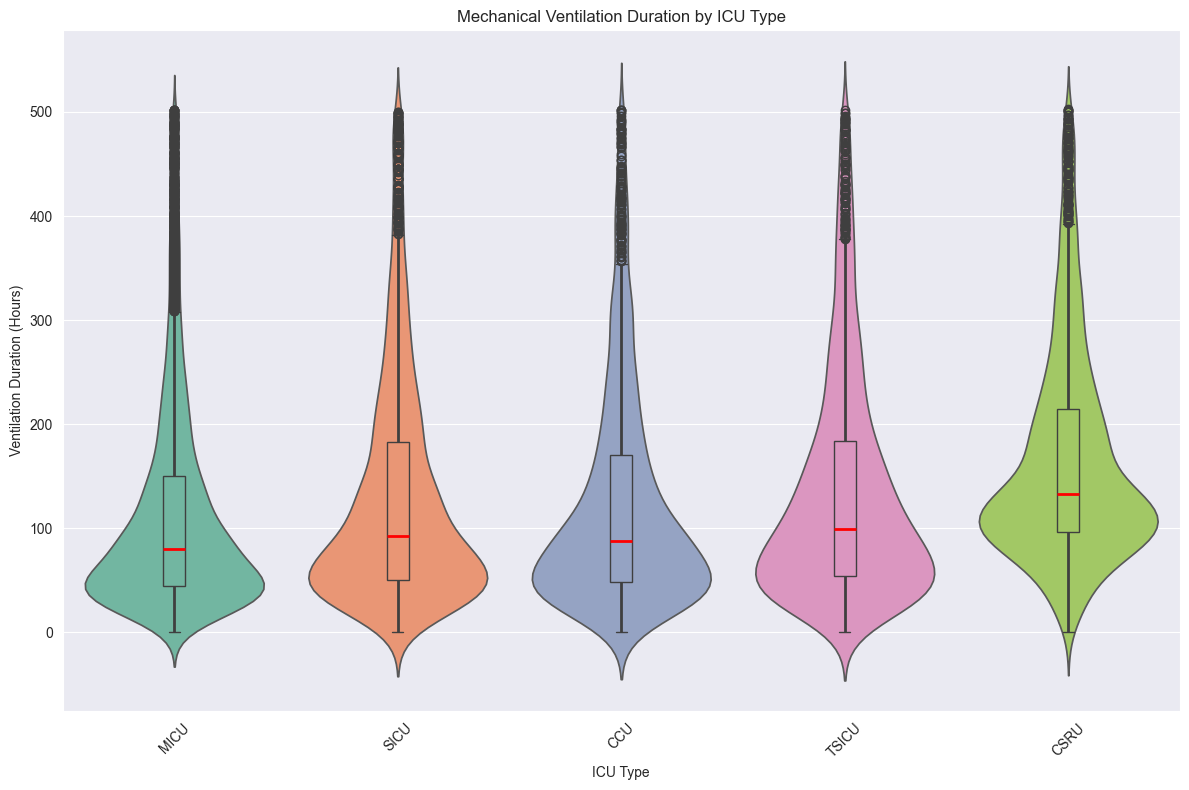

In [11]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(
    x='ICU_Type',
    y='Vent_Duration_Hours',
    hue='ICU_Type',
    data=plot_df,
    inner=None,
    palette='Set2',
    legend=False
)

# Add median and IQR using boxplot
sns.boxplot(
    x='ICU_Type',
    y='Vent_Duration_Hours',
    data=plot_df,
    width=0.1,
    showcaps=True,
    boxprops={'facecolor':'none'},
    showfliers=True,
    whiskerprops={'linewidth':2},
    medianprops={'color':'red', 'linewidth':2}
)

# Customize the plot
plt.title('Mechanical Ventilation Duration by ICU Type')
plt.xlabel('ICU Type')
plt.ylabel('Ventilation Duration (Hours)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
